# Walk-Through: Create a Machine Learning Algorithm
In this walk through, we will look at the steps used to create a Python script that can analyze a dataset of product reviews and intelligently determine whether a given review is positive or negative, based on the words used in the review.

This activity uses the 5-core Electronics dataset from Julian McCauley's <a href="http://jmcauley.ucsd.edu/data/amazon/" target="_blank">Amazon review data</a>. 

Each record includes data about the user who posted the data, what product is being reviewed, the text of the review, and whether the review is negative or positive. As an example:

    {
      "reviewerID": "A2SUAM1J3GNN3B",
      "asin": "0000013714",
      "reviewerName": "J. McDonald",
      "helpful": [2, 3],
      "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
      "overall": 5.0,
      "summary": "Heavenly Highway Hymns",
      "unixReviewTime": 1252800000,
      "reviewTime": "09 13, 2009"
    }

The `overall` value is a range of 1 to 5, and we are using it as a label to determine whether the review is negative or positive. Specifically, a review of 1 or 2 is Negative and a review of 5 is Positive.

## Step 0
Before we can build the script, we need to include Python packages that we will use to create the algorithm, incluing:
* `nltk`: The Natural Language Toolkit, which we use to process and analyze the text
* `tensorflow`: Supports machine learning
* `NumPy`: Used to organize data in arrays


In [1]:
# load appropriate packages 
import nltk
import tensorflow as tf
from tensorflow import keras
import numpy as np
print("Ready")

Ready


## Step 1: Import the Data
Once Python is set up, we are ready to retrieve data stored in a JSON file to use in our machine learning algorithm.

We will pull two separate sets of data: one with negative (1- or 2-star ratings) reviews and one with positive (5-star) reviews. In addition, we want each dataset to have the same number of records, so that the algorithm isn't overwhelmed with a high percentage of either type of review.

We import 50,000 negative reviews to a list named `dataset1`.

We import 50,000 positive reviews to a list named `dataset2`.

In [2]:
import json 
dataset= []
dataset1 =[]
dataset2 =[]
num_samples = 25000
validation_size = 5000 
test_size=0.4

file_path = "/Users/haythembalti/Downloads/reviews_Electronics_5.json"
#file_path = "/Users/haythembalti/Downloads/reviews_Amazon_Instant_Video_5.json"

with open(file_path) as data_file:
    data=data_file.read()
    lines = data.split("\n")
    lines = lines[:-1] #remove last empty line
    dataset = [json.loads(line) for line in lines] #parse each line in the JSON file into a Python dictionary 
    dataset1 = list(filter(lambda line: line['overall'] == 1 or line['overall'] == 2 , dataset))[:num_samples] #filter negative reviews
    dataset2 = list(filter(lambda line: line["overall"] == 5 , dataset))[:num_samples] #filter positive reviews
        

print(len(dataset1))
print(len(dataset2))
print(dataset[0])
print(dataset1[0]) #negative review 
print(dataset2[0]) #positive review


25000
25000
{'reviewerID': 'AO94DHGC771SJ', 'asin': '0528881469', 'reviewerName': 'amazdnu', 'helpful': [0, 0], 'reviewText': 'We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!', 'overall': 5.0, 'summary': 'Gotta have GPS!', 'unixReviewTime': 

We now combine the separate datasets into a single list named `dataset`.

In [3]:
#dataset 1: list of negative reviews 
#dataset  2: list of positive reviews 
dataset = dataset1 + dataset2
print("Number of reviews in the dataset: " + str(len(dataset)))

Number of reviews in the dataset: 50000


## Step 2: Split the Dataset
Right now, the dataset includes all attributes from the original reviews, including things like the reviewer's name and ID, the product ID, and when the review was posted. For our analysis, though, the only attributes that matter is the overall rating (which we can interpret as being negative or positive) and the text of the review itself.

We split the dataset into two lists:
* The first list (`dataset_labels`) will include the labels for each review, where 0 is negative and 1 is positive.
* The second list (`dataset_text`) will include only the text from the reviewText attribute in each record.



In [4]:
### Split the dataset into two different lists.
dataset_text = list()
dataset_labels = list()
### Iterate through the dataset
for row in dataset:
    if row['overall'] == 1 or row['overall'] == 2:
        dataset_labels.append(0)
    elif row['overall'] == 5:
        dataset_labels.append(1)
    else:
        continue
    dataset_text.append(row['reviewText'])
print("Ready")

Ready


## Step 3: Convert Text to Integers
Our machine learning algorithm cannot process text directly, so we need to convert the words to sequences of integers, where each integer represents a specific word in the dictionary. To this end, we will use the Keras IMDB datasets to map the reviews, and use that to create a dictionary that uses the word as a key and the index of the word's token from the `imdb.get_word_index`, which is built into the TensorFlow packages.

We reserve the first four index values for padding, which will be explained in more detail later, and add 3 to the current index value for each word to create the required offset.

In [5]:
### we use the imdb dataset' index values to map our reviews dataset
imdb = keras.datasets.imdb

# we create a word_index dictionary where the key is a word and the value is an index of that token,
# using a prebuilt word_index dictionary from the imdb database
word_index = imdb.get_word_index()

# add these key,value pairs to the word_index dictionary for padding
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

# because of the padding we offset the original index values by 3
word_index = {k:(v + 3) for k,v in word_index.items()} 
print(word_index["ready"])
print(word_index["walk"])
print(word_index["omg"])
print("Ready")

Ready
1623
1135
11958


## Step 4: Tokenize the Review Text
The next step is to tokenize the review text, a process that uses NLTK to identify the individual words in a string using spaces and punctuation marks as separators.

We then process each tokenized word using the following steps:
1. We look for the word in the word_index dictionary.
1. If the word exists in the dictionary, we add the corresponding index value to a new list.
1. If the word is not in the dictionary, we ignore it.

For comparison, the script below outputs the original text version of the first review in the the list as well as the indexed version of that entry.

In [6]:
### Tokenize each review in the dataset 
### then map each token to an index and store the results in dataset_reviews_tokens_index
### use the word_tokenize from the nltk package to perform a quick tokenization.
### dataset_reviews_tokens_index is a list that will contain the list of token indexes of each reviews 
dataset_index = list()
for text in dataset_text:
    #tokenize each review
    tokens = nltk.word_tokenize(text)
    tokens_index = list()
    #iterate through indexes
    for token in tokens:
        #check if token exist in word_index
        if token in word_index:
            # append the index of the token to the list tokens_index, 
            # which contains the list of indexes of each review
            tokens_index.append(word_index[token])
        #if token doesn't exist in word_index then we ignore it.  
        else:
            continue
    # append the list of tokens_index to dataset_reviews_tokens_index
    dataset_index.append(tokens_index)
print("Original review:  " + str(dataset_text[0]))
print("\nIndexed  review:  " + str(dataset_index[0]))

Original review:  I'm a professional OTR truck driver, and I bought a TND 700 at a truck stop hoping to make my life easier.  Rand McNally, are you listening?First thing I did after charging it was connect it to my laptop and install the software and then attempt to update it.  The software detected a problem with my update and wanted my home address so I could be sent a patch on an SD card.  Hello?  I don't think I'm all that unusual; my home address is a PO box that a friend checks weekly and that I might get to check every six months or so.  I live in my truck and at truck stops.  If you need to make a patch available on an SD card then you should send the SD cards to the truck stops where the devices are sold.  I ran the update program multiple times until the program said that the TND 700 was completely updated.I programmed in the height (13'6"), the length (53') and the weight (80,000#) of my rig and told it that I preferred highways.  I was parked at a truck stop in the Cincinna

## Step 5: Truncate the Review Text
The ML algorithm requires that each review has the same length. 

The following script will truncate any reviews that include more than 256 words and add padding (whose index value was defined as 0 in an earlier step) to make shorter reviews longer.

We output the original indexed review and the padded review. Note that the original version of the review has 370 words, but the new version has only 256 words.

In [7]:
dataset_padded = keras.preprocessing.sequence.pad_sequences(dataset_index,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

print("This review has " + str(len(dataset_index[0])) + " words.")
print("Indexed review:  " + str(dataset_index[0]))

print("\nThis review has " + str(len(dataset_padded[0])) + " words.")
print("Padded review:  " + str(dataset_padded[0]))

This review has 373 words.
Indexed review:  [27038, 6, 1624, 2832, 2658, 5, 1247, 6, 9623, 33, 6, 2832, 570, 1383, 8, 97, 61, 113, 3425, 26, 25, 2621, 155, 122, 103, 13506, 12, 16, 3807, 12, 8, 61, 20018, 5, 24950, 4, 10869, 5, 95, 589, 8, 6940, 12, 10869, 32449, 6, 439, 19, 61, 6940, 5, 473, 61, 344, 5517, 38, 100, 30, 1412, 6, 10089, 23, 35, 3155, 81, 59139, 104, 27038, 32, 15, 1732, 61, 344, 5517, 9, 6, 953, 15, 6, 464, 10138, 7652, 5, 15, 238, 79, 8, 808, 175, 1446, 1928, 42, 38, 412, 11, 61, 2832, 5, 33, 2832, 3003, 25, 359, 8, 97, 6, 10089, 1439, 23, 35, 3155, 95, 25, 144, 2222, 4, 4320, 8, 4, 2832, 3003, 121, 4, 5363, 26, 2962, 2178, 4, 6940, 2081, 2584, 211, 366, 4, 2081, 301, 15, 4, 9623, 16, 340, 16266, 11, 4, 5673, 2001, 758, 1086, 17451, 4, 1615, 20442, 758, 5, 4, 3324, 7, 61, 18499, 5, 579, 12, 15, 5947, 38626, 16, 11995, 33, 6, 2832, 570, 11, 4, 1609, 375, 9050, 16, 44, 1119, 2064, 180, 4, 172, 16798, 21, 23, 4, 85, 499, 7, 12, 6, 378, 7, 13078, 2768, 1699, 301, 8, 79, 23

## Step 6: Create the Training and Testing Datasets
A basic part of machine learning is to create two different datasets: one that will train the algorithm and the other that can test the accuracy of the predictions. 

A ratio of 70% learning data and 30% testing data is generally recommended. 
In the code, we use scikit-learn to split the data into four separate lists:
* `train_x`: a list that contains the training data
* `test_x`: a list that contains the testing data
* `train_y`: a list that contains labels of the training data
* `test_y`: a list that contains labels of the testing data

In [8]:
### Split data into training and testing data using the sklearn package
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(dataset_padded, dataset_labels, test_size=test_size)
print("Ready")

Ready


## Step 7: Training
Now we are ready to start the training processes. 

For the training, we will use the full vocabulary list from `word_index`. We will then use the Keras API to define the training model we want to use. This model includes the following layers:
* an input layer
* a pooling layer, which down samples the dataset into average values
* a dense layer, with 16 nodes
* an ouput layer with a single node

The single node in the output layer will contain the confidence level that a review is positive or negative.

In [9]:
### Training 
vocab_size = 88588 

### Create an empty sequential model 
model = keras.Sequential()

### Add input layer
model.add(keras.layers.Embedding(vocab_size, 16))

### Add a GlobalAveragePooling1D layer to the model
model.add(keras.layers.GlobalAveragePooling1D())

### Add a Dense layer to the model with 16 nodes
### tf.nn.relu Computes rectified linear: max(features, 0).
model.add(keras.layers.Dense(16, activation=tf.nn.relu))

### Add an output layer to the model with one single node 
### tf.nn.sigmoid Computes sigmoid of x element-wise Specifically, y = 1 / (1 + exp(-x)).
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

### Display the summary of the model 
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1417408   
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,417,697
Trainable params: 1,417,697
Non-trainable params: 0
_________________________________________________________________


## Step 7: Define the Accuracy of the Model
In this step, we define the model's accuracy, the loss function, and  the optimizer.

In [10]:
### Define the optimizer as adam 
### Define the loss function as a mean_squared_error
### Define the performance metric as the accuracy of the model (rate of correct guesses)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['acc'])
print("Ready")

Ready


## Step 8: Define the Validation Set
In this step, we separate the validation data from the training data.

In [11]:
### extract the validation set from the training set 
x_val = train_x[:validation_size]

### extract the rest of the data as the training set 
partial_x_train = train_x[validation_size:]

### extract the labels of the validation set from the training set 
y_val = train_y[:validation_size]

### extract the rest of the labels as the training labels 
partial_y_train = train_y[validation_size:]

print("Ready")

Ready


## Step 9: Run the Training Model
Now we run the module using the training data and the validation data, for 25 epochs. 

The `verbose = 1` option allows us to see each epoch as it runs, including loss levels and accuracy ratings for each epoch.

The accuracy levels will rise with each epoch, as the machine learns how to interpret the data.

In [12]:
#### Run training on the training partial_x_train data 
### We provide also the validation data as input as well. 
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 25000 samples, validate on 5000 samples
Epoch 1/25
25000/25000 [==============================] - 4s 161us/sample - loss: 0.2485 - acc: 0.5779 - val_loss: 0.2465 - val_acc: 0.6094
Epoch 2/25
25000/25000 [==============================] - 4s 148us/sample - loss: 0.2415 - acc: 0.6173 - val_loss: 0.2383 - val_acc: 0.6146
Epoch 3/25
25000/25000 [==============================] - 4s 155us/sample - loss: 0.2311 - acc: 0.6378 - val_loss: 0.2277 - val_acc: 0.6486
Epoch 4/25
25000/25000 [==============================] - 4s 155us/sample - loss: 0.2171 - acc: 0.6772 - val_loss: 0.2102 - val_acc: 0.7026
Epoch 5/25
25000/25000 [==============================] - 4s 153us/sample - loss: 0.1959 - acc: 0.7489 - val_loss: 0.1858 - val_acc: 0.7594
Epoch 6/25
25000/25000 [==============================] - 4s 154us/sample - loss: 0.1699 - acc: 0.8069 - val_loss: 0.1604 - val_acc: 0.8250
Epoch 7/25
25000/25000 [==============================] - 4s 156us/sample - loss: 0.1475 - acc: 0.8382 - val_lo

## Step 10: Test the Model
Finally, we run the test data through the model.

The accuracy rate will be different on each run, but it should be reasonably close to the accuracy rate on the final epoch in the training model.

In [13]:
### Apply model on testing data 
results = model.evaluate(test_x, test_y)
print(results)

20000/20000 [==============================] - 1s 27us/sample - loss: 0.0879 - acc: 0.8835
[0.0879468368768692, 0.8835]


## Step 11: Visualize the Results
We can now use the MatPlotLib Python library to generate visualizations of the training results.

First, we look at the loss values for both training and validation.

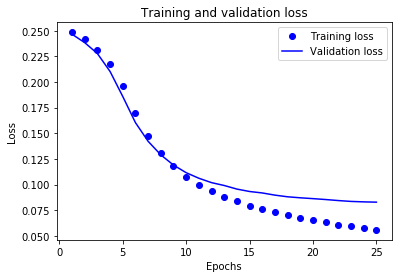

In [16]:
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.clf() 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Finally, we look at the accuracy of the training and validation epochs.

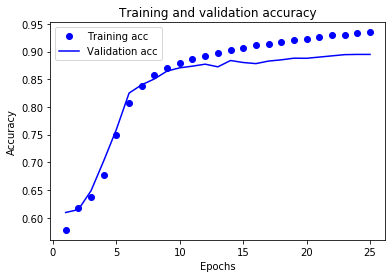

In [15]:
plt.clf()  
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()